This notebook is meant to consider the idea of using the dual update step in ADMM to motivate the penalty parameter. We look at:
1. Different stating $\lambda$
2. $\lambda$ updates
3. Looking at $\lambda$ as scaling factor input and plotting geographically

__Other Notes__
1. Run `11` might be particularly interesting because it started off with abnormal line search terminations for the first two iterations, then from iteration 3 on, we had 20 line search steps to avoid that.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [2]:
from generate_opt_objects import A_b_generation

In [3]:
# paths
OBS_FP = '../fixed_optimization_inputs/y_affine_corrected.npy'

In [4]:
# get necessary objects
with open(OBS_FP, 'rb') as f:
    y_obs = np.load(f)
    
# gosat data
with open('../fixed_optimization_inputs/gosat_df_jan1_aug31_2010.csv', 'rb') as f:
    gosat_df = pd.read_csv(f)
L_inv_vec = 1 / gosat_df.xco2_unc.values
    
# tranform the data
y_tilde = np.multiply(L_inv_vec, y_obs)

CONSTR_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization/data/sign_corrected'
A, b = A_b_generation(
    box_constraint_fp=CONSTR_DIR + '/scipy_bnds.pkl'
)

FUNC_FP = '/Users/mikestanley/Research/Carbon_Flux/optimization'
FUNC_FP += '/src_admm/data/carbon_flux/objects/na_june_functional.npy'
with open(FUNC_FP, 'rb') as f:
    h = np.load(f)

In [5]:
print(A.shape)
print(h.shape)

(11120, 26496)
(26496,)


# Different starting values for $\lambda$

Runs and their starting points
1. `09`: all 0s -- first attempt with the UEP
2. `11`: stopping position of LEP `08`

#### `09`

In [6]:
with open('./data/carbon_flux/results/09/intermediate_starts/lambda_start_it0.npy', 'rb') as f:
    lambda_start_09 = np.load(f)

In [7]:
np.where(lambda_start_09 != 0)

(array([], dtype=int64),)

#### `11`

In [8]:
with open('./data/carbon_flux/results/11/intermediate_starts/lambda_start_from_neg_lep08.npy', 'rb') as f:
    lambda_start_11 = np.load(f)

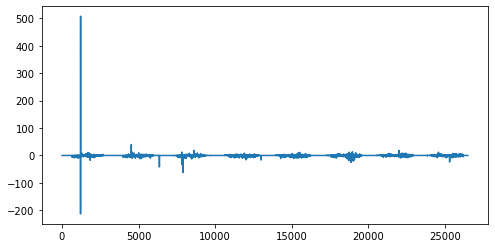

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(lambda_start_11)
plt.show()

# $\lambda$ updates

#### `09` - first UEP attempt

In [10]:
# final results
with open('./data/carbon_flux/results/09/opt_output_00.pkl', 'rb') as f:
    final_res_09 = pickle.load(f)

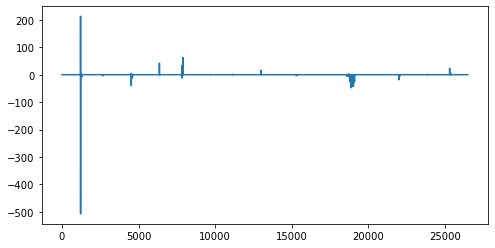

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(final_res_09['lambda_opt_vecs'][0])
plt.show()

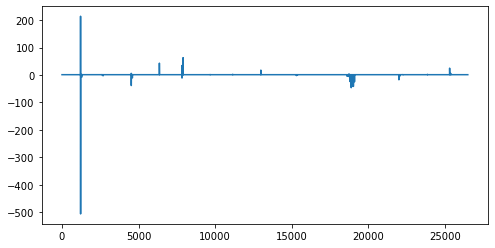

In [12]:
grad_dual = h - A.T @ final_res_09['c_opt_vecs'][0] - final_res_09['KTw_vecs'][0]
plt.figure(figsize=(8, 4))
plt.plot(np.ones(h.shape) + 1e3 * grad_dual)
plt.show()

# Looking at $\lambda$ as scaling factor input to forward model

When calling the forward model during the gradient evaluation, we send the following vector into the forward model (i.e., as a scaling factor)
\begin{equation}
    \lambda_k -\mu (h - A^T c_k + K^T w_k)
\end{equation}

Is this a realistic input? Can we use $\mu$ to guarantee this is a realistic input?

####  `09`

In [13]:
c_k = final_res_09['c_opt_vecs'][0]
KTw_k = final_res_09['KTw_vecs'][0]
lambda_k = final_res_09['lambda_opt_vecs'][0]

forward_model_input = lambda_start_09 - 1e3 * (h - A.T @ c_k + KTw_k)

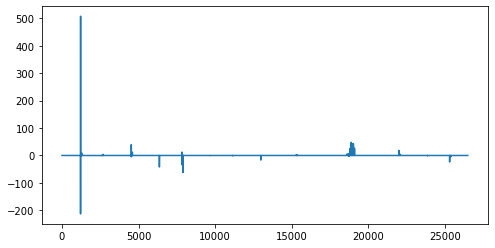

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(forward_model_input)
plt.show()

#### `11`

In [15]:
# final results
with open('./data/carbon_flux/results/11/final_results_00_01.pkl', 'rb') as f:
    final_res_11_00_01 = pickle.load(f)
    
with open('./data/carbon_flux/results/11/opt_output_03.pkl', 'rb') as f:
    final_res_11_02_03 = pickle.load(f)

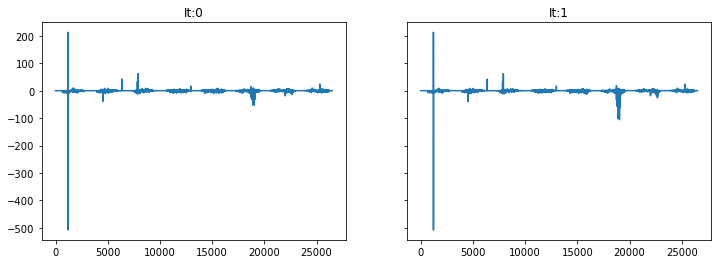

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)
ax[0].plot(final_res_11_00_01['lambda_opt_output']['vectors'][0], label='It:0')
ax[1].plot(final_res_11_00_01['lambda_opt_output']['vectors'][1], label='It:1')
ax[0].set_title('It:0')
ax[1].set_title('It:1')
plt.show()

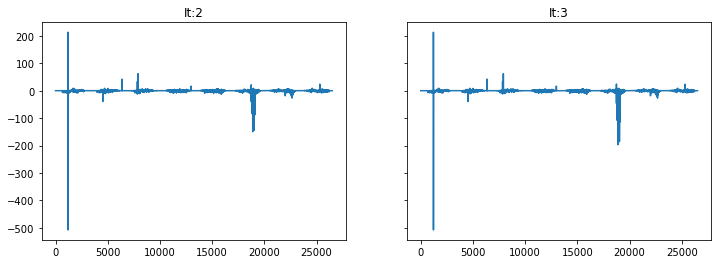

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)
ax[0].plot(final_res_11_02_03['lambda_opt_vecs'][2], label='It:2')
ax[1].plot(final_res_11_02_03['lambda_opt_vecs'][3], label='It:3')
ax[0].set_title('It:2')
ax[1].set_title('It:3')
plt.show()

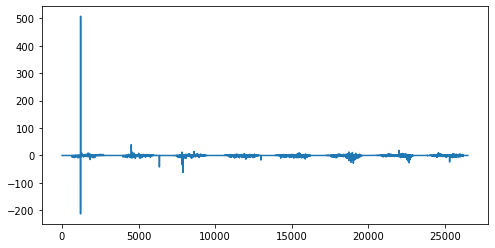

In [18]:
# computing the quantity above
lambda_k = final_res_11_00_01['lambda_opt_output']['vectors'][0]
c_k = final_res_11_00_01['c_opt_output']['vectors'][0]
KTw_k = final_res_11_00_01['KTw_vecs'][0]

forward_model_input = lambda_k - 1e3 * (h - A.T @ c_k + KTw_k)
plt.figure(figsize=(8, 4))
plt.plot(forward_model_input)
plt.show()

##### Visualizing the scaling factors geographically

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import colors

In [20]:
def plot_month_sfs(sf_arr, lon, lat, write_loc=None):
    """
    Plot a global heatmap of scale factors for a single month

    Parameters:
        sf_arr    (np arr) : {lon} x {lat} array
        lon       (np arr) :
        lat       (np arr) :
        write_loc (str)    : file path to which plot should be written

    Returns:
        None - but write plot to file
    """
    assert sf_arr.shape[0] == 72
    assert sf_arr.shape[1] == 46

    fig = plt.figure(figsize=(12.5, 6))
    norm = colors.TwoSlopeNorm(vcenter=1)

    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
    contour = ax.contourf(
        lon, lat, sf_arr.T, levels=100,
        transform=ccrs.PlateCarree(), cmap='bwr', norm=norm
    )
    fig.colorbar(contour, ax=ax, orientation='vertical', extend='both')
    ax.add_feature(cfeature.COASTLINE)

    if write_loc:
        plt.savefig(write_loc)
    else:
        plt.show()

In [21]:
# read in lon/lat
with open('/Users/mikestanley/Research/Carbon_Flux/data/lon_lat_arrs/lon.npy', 'rb') as f:
    lon = np.load(file=f)
with open('/Users/mikestanley/Research/Carbon_Flux/data/lon_lat_arrs/lat.npy', 'rb') as f:
    lat = np.load(file=f)

In [22]:
# read in the mmonthly control fluxes
with open('../../data/monthly_flux_arrs/ct_monthly_flux.npy', 'rb') as f:
    ct_monthly_flux = np.load(f)
ct_monthly_flux.shape

(12, 72, 46)

In [23]:
# reshape the scaling factors
sf_arr = np.reshape(a=forward_model_input, newshape=(8, 46, 72), order='C')
sf_arr = np.swapaxes(a=sf_arr, axis1=1, axis2=2)

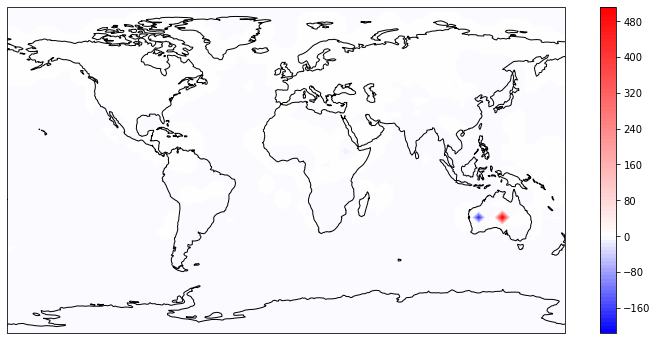

In [25]:
# january
plot_month_sfs(sf_arr=sf_arr[0], lon=lon, lat=lat)

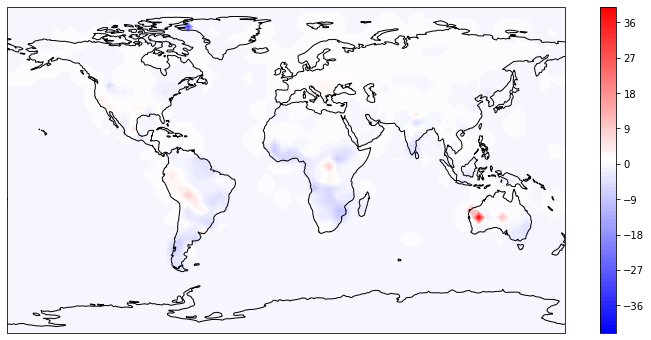

In [26]:
# February
plot_month_sfs(sf_arr=sf_arr[1], lon=lon, lat=lat)

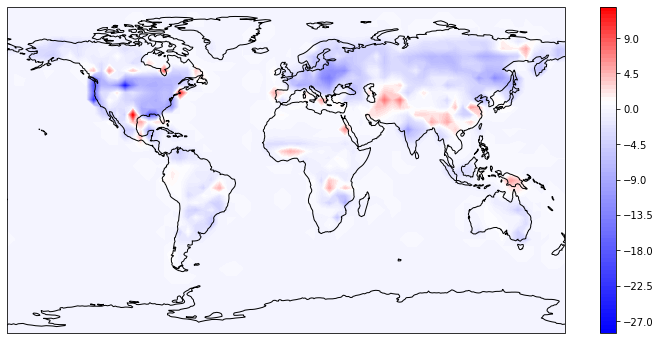

In [27]:
# June
plot_month_sfs(sf_arr=sf_arr[5], lon=lon, lat=lat)